# Interactive Occlusion Heatmap slider for all models

For a given patient id the occlusion heatmap is calculated for all models and displayed in a slider.
The size of the occlusion can be adjusted manually.

### Imports

In [45]:
%matplotlib inline
import os
import h5py
import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

import tensorflow as tf
from tensorflow import keras

print("TF  Version",tf.__version__)

TF  Version 2.4.0


In [46]:
import functions_model_definition as md
import functions_read_data as rdat
import functions_occlusion as oc
import functions_gradcam as gc
import functions_plot_heatmap as phm
import functions_slider as sl

In [47]:
# check and set path before loading modules
print(os.getcwd())
DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/"
if os.getcwd() != DIR:
    os.chdir(DIR)

/tf/notebooks/schnemau/xAI_stroke_3d


### Load Data and Set Parameters

In [56]:
# Define the path + output path:
DATA_DIR = DIR + "data/"

#version = "andrea" # one of:
version = "10Fold_sigmoid_V0" # one of:
# 10Fold_sigmoid_V0, 10Fold_sigmoid_V1, 10Fold_sigmoid_V2, 10Fold_sigmoid_V2f, 10Fold_sigmoid_V3
# 10Fold_softmax_V0, 10Fold_softmax_V1, andrea
save_plot = False

# Define Model Version
model_version = 1

# define paths
WEIGHT_DIR, DATA_OUTPUT_DIR, PIC_OUTPUT_DIR, pic_save_name = rdat.dir_setup(
    DIR, version, model_version)

In [57]:
## load images and ids
(X_in, pat, id_tab, all_results, num_models) = rdat.version_setup(
    DATA_DIR = DATA_DIR, version = version, model_version = model_version)

In [58]:
## load patient data
PAT_CSV_DIR = "/tf/notebooks/schnemau/xAI_stroke_3d/data/baseline_data_zurich_prepared0.csv" 
pat_dat = pd.read_csv(PAT_CSV_DIR, sep=";")
pat_dat

,p_id,mrs3,age,sexm,nihss_baseline,mrs_before,stroke_beforey,tia_beforey,ich_beforey,rf_hypertoniay,rf_diabetesy,rf_hypercholesterolemiay,rf_smokery,rf_atrial_fibrillationy,rf_chdy,eventtia,iaty,ivty
0,101,1,"85,6",0,9.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,NaN,NaN
1,102,1,"66,7",1,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,NaN,NaN
2,103,0,"29,2",0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,NaN,NaN
3,104,0,83,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,NaN,NaN
4,105,6,"89,2",0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,540,2,80,0,7.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0.0,0
514,541,0,19,1,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,1
515,542,1,68,1,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1,0.0,0
516,543,4,74,0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,0


## Model

In [59]:
# define model
(input_dim, output_dim, LOSS, layer_connection, last_activation) = md.model_setup(version)

model_3d = md.stroke_binary_3d(input_dim = input_dim,
                               output_dim = output_dim,
                               layer_connection = layer_connection,
                               last_activation = last_activation)

model_3d.compile(
    loss=LOSS,
    optimizer=keras.optimizers.Adam(learning_rate=5*1e-5),
    metrics=["acc", tf.keras.metrics.AUC()]
)

# define if print should be enabled
check_print = True


In [60]:
WEIGHT_DIR

'/tf/notebooks/schnemau/xAI_stroke_3d/weights/10Fold_sigmoid_V0/'

In [13]:
# Define Model Name
generate_model_name = md.set_generate_model_name(
    model_version = model_version, 
    layer_connection = layer_connection, 
    last_activation = last_activation, 
    path = WEIGHT_DIR)                                                 


# Occlusion without slider

In [14]:
(res_table, res_images, res_model_names) = gc.get_img_and_models(
        [21], results = all_results, pats = pat, imgs = X_in, 
        gen_model_name = generate_model_name,
        num_models = num_models)

In [15]:
res_table

,index,p_idx,p_id,mrs,unfavorable,fold0,fold1,fold2,fold3,fold4,...,y_pred_model_2,y_pred_model_3,y_pred_model_4,y_pred_linear_avg,y_pred_trafo_avg,threshold,y_pred_class,y_pred_std,y_pred_unc,pred_correct
0,0,14,21,1.0,0,test,train,train,train,train,...,0.042417,0.029797,0.012347,0.022105,0.01927,0.225491,0,0.013555,0.031232,True


Two different occlusions are recommended.  
However, the occlusion can also be defined by the user. The third row of the following output must be all 0 and the fourth row must be True and the occlusion will work.

In [16]:
### occlusion
# occ_size = (16, 16, 12)
# occ_stride = 8
occ_size = (14, 14, 10)
occ_stride = 6
print("number of occlusions: ", int(np.prod(((np.array(res_images.shape[1:4]) - occ_size) / occ_stride) + 1)))
print("number of occlusions per axis: ", ((np.array(res_images.shape[1:4]) - occ_size) / occ_stride) + 1)
print((np.asarray(res_images.shape[1:4]) - occ_size) % occ_stride) # all must be zero
print(all(np.array(occ_size) > occ_stride)) # must be true
print(np.array(res_images.shape[1:4]) / occ_size) # if all same, then same ratio of occ_size to image size

number of occlusions:  1600
number of occlusions per axis:  [20. 20.  4.]
[0 0 0]
True
[9.14285714 9.14285714 2.8       ]


In [17]:
import time
from importlib import reload
reload(oc)

start = time.time()
(heatmap, resized_img, max_hm_slice, hm_mean_std) =  oc.volume_occlusion(
    volume = res_images, 
    res_tab = res_table, 
    occlusion_size = np.array(occ_size), 
    normalize = True,
    both_directions = False,
    invert_hm = "pred_class",
    cnn = model_3d,
    model_names = res_model_names[0][:], # select model
    occlusion_stride = occ_stride)

end = time.time()
print(end - start)

324.5409941673279


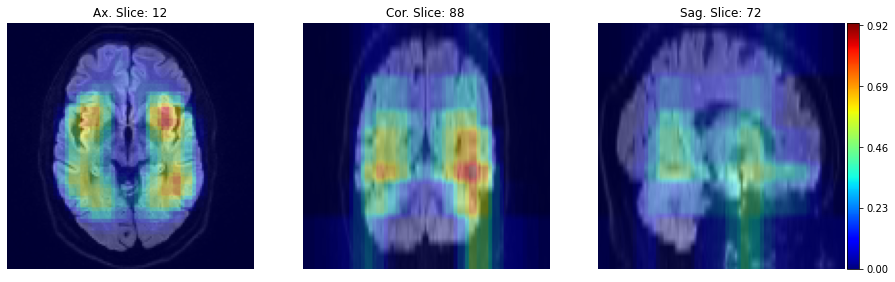

In [18]:
phm.plot_heatmap(np.squeeze(resized_img, axis=-1), np.squeeze(heatmap, axis=-1),
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

# Occlusion Slider

patient id:  162
age:  75,3
true mrs:  0.0
true class:  0
pred class: 0
pred prob (class 1):  0.2245433
pred uncertainty:  0.35809875
max slices: (10, 44, 74)


TypeError: Invalid shape (128, 128, 1) for image data

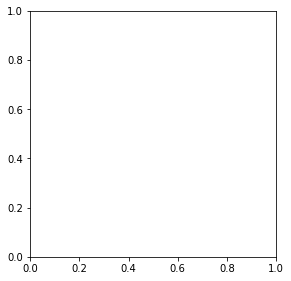

In [19]:
# occ_size = (16, 16, 12)
# occ_stride = 8
occ_size = (14, 14, 10)
occ_stride = 6

sl.occlusion_interactive_plot(
    162, # patient id
    occ_size = occ_size, occ_stride = occ_stride,
    cnn=model_3d, all_results=all_results, pat=pat, X_in=X_in,
    generate_model_name=generate_model_name, num_models=num_models,
    pat_dat=pat_dat,
    pred_hm_only=True) # if True, only the heatmap for the predicted class is shown, otherwise also negative heatmaps are shown

### Maurice

In [11]:
print(X_in.shape)
print(np.expand_dims(X_in, axis = -1).shape)

(407, 128, 128, 28)
(407, 128, 128, 28, 1)


In [12]:
imgs22 = np.expand_dims(X_in, axis = -1)
np.array(imgs22)
imgs22[14]

array([[[[-0.5798917],
         [-0.5798917],
         [-0.5798917],
         ...,
         [-0.5798917],
         [-0.5798917],
         [-0.5798917]],

        [[-0.5798917],
         [-0.5798917],
         [-0.5798917],
         ...,
         [-0.5798917],
         [-0.536904 ],
         [-0.5798917]],

        [[-0.5798917],
         [-0.5798917],
         [-0.5798917],
         ...,
         [-0.5798917],
         [-0.5798917],
         [-0.5798917]],

        ...,

        [[-0.5798917],
         [-0.5798917],
         [-0.5798917],
         ...,
         [-0.5798917],
         [-0.536904 ],
         [-0.5798917]],

        [[-0.5798917],
         [-0.5798917],
         [-0.5798917],
         ...,
         [-0.5798917],
         [-0.5798917],
         [-0.5798917]],

        [[-0.5798917],
         [-0.5798917],
         [-0.5798917],
         ...,
         [-0.5798917],
         [-0.536904 ],
         [-0.5798917]]],


       [[[-0.5798917],
         [-0.5798917],
         [-0.5

In [13]:
occ_size = (14, 14, 10)
occ_stride = 6
volume = imgs22[14]#TODO
occlusion_size = np.array(occ_size)
normalize = True
both_directions = False
invert_hm = "pred_class"
occlusion_stride = occ_stride
input_shape = (128,128,28,1) #TODO
volume = volume.reshape(input_shape)

In [14]:
heatmap_prob_sum = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)
heatmap_occ_n = np.zeros((volume.shape[0], volume.shape[1], volume.shape[2]), np.float32)

In [15]:
X = []
xyz = []
for n, (x, y, z, vol_float) in enumerate(oc.iter_occlusion(
        volume, size = occlusion_size, stride = occlusion_stride)):
    X.append(vol_float.reshape(volume.shape[0], volume.shape[1], volume.shape[2], 1))
    xyz.append((x,y,z))

X = np.array(X)
out = model_3d.predict(X) # do prediction for all occlusions at once 

In [37]:
out

array([[0.16365772],
       [0.14762732],
       [0.15605837],
       ...,
       [0.14432353],
       [0.15703398],
       [0.16184306]], dtype=float32)

In [38]:
out[1,0]

0.14762732

In [39]:
for i in range(len(xyz)):
    x,y,z = xyz[i]
    heatmap_prob_sum[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += out[i,0]
    heatmap_occ_n[x:x + occlusion_size[0], y:y + occlusion_size[1], z:z + occlusion_size[2]] += 1

hm = heatmap_prob_sum / heatmap_occ_n # calculate average probability per voxel

In [40]:
hm

array([[[0.16365772, 0.16365772, 0.16365772, ..., 0.16335604,
         0.16335604, 0.16335604],
        [0.16365772, 0.16365772, 0.16365772, ..., 0.16335604,
         0.16335604, 0.16335604],
        [0.16365772, 0.16365772, 0.16365772, ..., 0.16335604,
         0.16335604, 0.16335604],
        ...,
        [0.16329187, 0.16329187, 0.16329187, ..., 0.16195145,
         0.16195145, 0.16195145],
        [0.16329187, 0.16329187, 0.16329187, ..., 0.16195145,
         0.16195145, 0.16195145],
        [0.16329187, 0.16329187, 0.16329187, ..., 0.16195145,
         0.16195145, 0.16195145]],

       [[0.16365772, 0.16365772, 0.16365772, ..., 0.16335604,
         0.16335604, 0.16335604],
        [0.16365772, 0.16365772, 0.16365772, ..., 0.16335604,
         0.16335604, 0.16335604],
        [0.16365772, 0.16365772, 0.16365772, ..., 0.16335604,
         0.16335604, 0.16335604],
        ...,
        [0.16329187, 0.16329187, 0.16329187, ..., 0.16195145,
         0.16195145, 0.16195145],
        [0.1

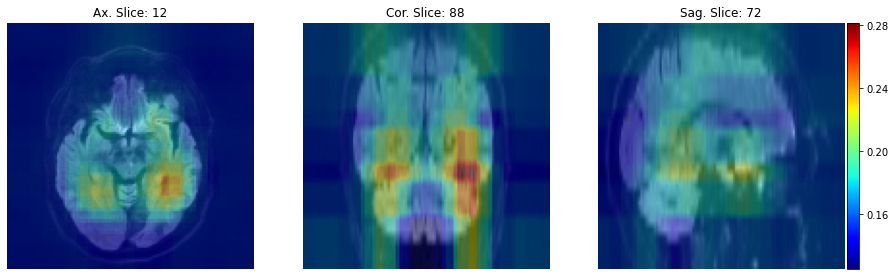

In [46]:
phm.plot_heatmap(X_in[14], hm,
                version = "overlay",
                mode = "def",
                slices = (88,72,12),
                hm_colormap="jet",
                hm_positive=True,
                colorbar=True)

In [47]:
X_in[0]

array([[[-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234],
        [-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234],
        [-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234],
        ...,
        [-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234],
        [-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234],
        [-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234]],

       [[-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234],
        [-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234],
        [-0.58437234, -0.58437234, -0.58437234, ..., -0.58437234,
         -0.58437234, -0.58437234],
        ...,
        [-0.58437234, -0.58437234, -0.58437234, ..., -